<a href="https://colab.research.google.com/github/jasvithaBuggana/From-Data-to-Decisions-Understanding-Layoff-Patterns/blob/main/Layoff_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# Load your dataset
file_path = r'/content/layoffs.csv'
data = pd.read_csv(file_path)

# Display the proportion of missing values in each column
missing_values = data.isnull().mean()
print("Missing values proportion:\n", missing_values)
data.shape

Missing values proportion:
 company                0.000000
location               0.000271
industry               0.000271
total_laid_off         0.343894
percentage_laid_off    0.357433
date                   0.000000
stage                  0.001895
country                0.000000
funds_raised           0.107230
dtype: float64


(3693, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              3693 non-null   object 
 1   location             3692 non-null   object 
 2   industry             3692 non-null   object 
 3   total_laid_off       2423 non-null   float64
 4   percentage_laid_off  2373 non-null   float64
 5   date                 3693 non-null   object 
 6   stage                3686 non-null   object 
 7   country              3693 non-null   object 
 8   funds_raised         3297 non-null   float64
dtypes: float64(3), object(6)
memory usage: 259.8+ KB


In [ ]:
data.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,UKG,Boston,HR,2200.0,0.14,2024-07-03,Unknown,United States,NaN
1,OpenText,Waterloo,Data,1200.0,0.02,2024-07-03,Post-IPO,Canada,1100.0
2,Unacademy,Bengaluru,Education,250.0,NaN,2024-07-02,Series H,India,838.0
3,Koo,Bengaluru,Consumer,NaN,1.00,2024-07-02,Unknown,India,51.0
4,Lightricks,Jerusalem,Consumer,70.0,0.12,2024-07-01,Series D,Israel,335.0


Data Pre-processing
1. Extract day, month, and year into separate columns

In [ ]:
import pandas as pd

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Extract day, month, and year into separate columns
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

# Drop the original 'date' column
data.drop(columns=['date'], inplace=True)

# Display the updated DataFrame
print(data)


            company        location        industry  total_laid_off  \
0               UKG          Boston              HR          2200.0   
1          OpenText        Waterloo            Data          1200.0   
2         Unacademy       Bengaluru       Education           250.0   
3               Koo       Bengaluru        Consumer             NaN   
4        Lightricks       Jerusalem        Consumer            70.0   
...             ...             ...             ...             ...   
3688        Service     Los Angeles          Travel             NaN   
3689   HopSkipDrive     Los Angeles  Transportation             8.0   
3690    Panda Squad     SF Bay Area        Consumer             6.0   
3691  Tamara Mellon     Los Angeles          Retail            20.0   
3692       EasyPost  Salt Lake City       Logistics            75.0   

      percentage_laid_off     stage        country  funds_raised  day  month  \
0                    0.14   Unknown  United States           NaN   

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              3693 non-null   object 
 1   location             3692 non-null   object 
 2   industry             3692 non-null   object 
 3   total_laid_off       2423 non-null   float64
 4   percentage_laid_off  2373 non-null   float64
 5   stage                3686 non-null   object 
 6   country              3693 non-null   object 
 7   funds_raised         3297 non-null   float64
 8   day                  3693 non-null   int32  
 9   month                3693 non-null   int32  
 10  year                 3693 non-null   int32  
dtypes: float64(3), int32(3), object(5)
memory usage: 274.2+ KB


2. Drop the missing rows from the target variable (total_laid_off)

In [ ]:

# Group the data by year and sum the total layoffs for each year
annual_layoffs = data.groupby('year')['total_laid_off'].sum().reset_index()

# Print the total layoffs for each year
print(annual_layoffs)


   year  total_laid_off
0  2020         80998.0
1  2021         15823.0
2  2022        165269.0
3  2023        263180.0
4  2024        104410.0


In [ ]:
# Remove rows with any missing values from the target variable
data_cleaned = data.dropna(subset = ['total_laid_off'])


In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2423 entries, 0 to 3692
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2423 non-null   object 
 1   location             2423 non-null   object 
 2   industry             2422 non-null   object 
 3   total_laid_off       2423 non-null   float64
 4   percentage_laid_off  1709 non-null   float64
 5   stage                2420 non-null   object 
 6   country              2423 non-null   object 
 7   funds_raised         2187 non-null   float64
 8   day                  2423 non-null   int32  
 9   month                2423 non-null   int32  
 10  year                 2423 non-null   int32  
dtypes: float64(3), int32(3), object(5)
memory usage: 198.8+ KB


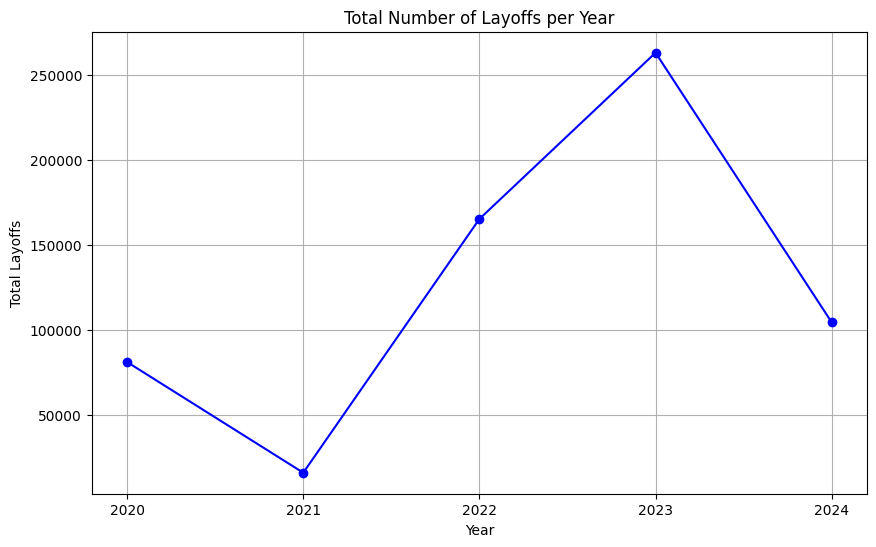

In [ ]:
import matplotlib.pyplot as plt

# Group the data by year and sum the total layoffs for each year
annual_layoffs = data_cleaned.groupby('year')['total_laid_off'].sum().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(annual_layoffs['year'], annual_layoffs['total_laid_off'], marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Total Number of Layoffs per Year')
plt.xlabel('Year')
plt.ylabel('Total Layoffs')
plt.xticks(annual_layoffs['year'])  # Set x-ticks to be the years only
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Define transformers for numeric and categorical features
numeric_features = ['percentage_laid_off', 'funds_raised', 'day', 'month', 'year']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_features = ['company', 'location', 'industry', 'stage', 'country']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into features and target
X = data_cleaned.drop(columns=['total_laid_off'])
y = data_cleaned['total_laid_off']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__num_leaves': [31, 50, 100]
    }
}

# Evaluate and tune models
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    param_grid = param_grids[model_name]

    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    # Best model from GridSearch
    best_model = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} Best Parameters: {grid_search.best_params_}')
    print(f'{model_name} Metrics:')
    print(f'  MAE: {mae}')
    print(f'  RMSE: {rmse}')
    print(f'  R^2: {r2}')
    print()


Random Forest Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Random Forest Metrics:
  MAE: 199.20765979381443
  RMSE: 553.0055048116703
  R^2: -0.40508402839342095

Gradient Boosting Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
Gradient Boosting Metrics:
  MAE: 215.14662818119774
  RMSE: 708.0974580660004
  R^2: -1.3037187603130191

XGBoost Best Parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
XGBoost Metrics:
  MAE: 219.28884562757827
  RMSE: 730.4274507147342
  R^2: -1.4513061850240074

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 1938, number of used features: 66
[LightGBM] [Info] Start training from score 269.752838
LightGBM Be

In [ ]:
# Filter data for the year 2024
data_2024 = data_cleaned[data_cleaned['year'] == 2024]

# Predict the number of layoffs for 2024
# We use .loc to handle the case where data_2024 might be empty
data_2024['predicted_total_laid_off'] = best_pipeline.predict(data_2024.drop(columns=['total_laid_off']))

# Calculate the total number of layoffs predicted for 2024
# Use .sum() on the Series, which will return 0 if the Series is empty
total_laid_off_2024 = data_2024['predicted_total_laid_off'].sum()

# Print the result
print(f'Total predicted number of layoffs in 2024: {total_laid_off_2024}')


Total predicted number of layoffs in 2024: 21821.25


<ipython-input-52-149fa6b78521>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['predicted_total_laid_off'] = best_pipeline.predict(data_2024.drop(columns=['total_laid_off']))
